In [117]:
%load_ext autoreload
%autoreload

from retro_branching.utils import get_most_recent_checkpoint_foldername, PlotAesthetics

import glob
import gzip
import pickle
from collections import defaultdict
import copy
import numpy as np
import scipy.stats as st
import math
from ordered_set import OrderedSet

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from tabulate import tabulate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Config

In [154]:
# scip_params = 'default'
scip_params = 'gasse_2019'


# # SET COVER 
# n_rows=100 n_cols=100
agent_to_path = {'IL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/gnn_341_checkpoint_120/rl_validator/rl_validator_1/',
                 'RL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_100_n_cols_100/baselines/dqn_gnn_1094_checkpoint_108/rl_validator/rl_validator_1/',}

# # n_rows=165 n_cols=230
# agent_to_path = {'IL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_165_n_cols_230/baselines/gnn_356_checkpoint_104/rl_validator/rl_validator_1/',
#                  'RL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_165_n_cols_230/baselines/dqn_gnn_1407_checkpoint_370/rl_validator/rl_validator_1/',}
agent_to_path = {
                 'IL': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_165_n_cols_230/scip_{scip_params}/baselines/gnn_356_checkpoint_104/rl_validator/rl_validator_1/',
                 'RL': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_165_n_cols_230/scip_{scip_params}/baselines/dqn_gnn_1491_checkpoint_40/rl_validator/rl_validator_1/',
                }

# # n_rows=500 n_cols=1000
# agent_to_path = {'IL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/gnn_343_checkpoint_233/rl_validator/rl_validator_1/',
#                  'RL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/dqn_gnn_1236_checkpoint_457/rl_validator/rl_validator_1/',}
# agent_to_path = {'RL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/dqn_gnn_1094_checkpoint_108/rl_validator/rl_validator_1/',
#                  'SL': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/gnn_341_checkpoint_120/rl_validator/rl_validator_1/'}
agent_to_path = {
                 'IL': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/gnn_361_checkpoint_139/rl_validator/rl_validator_1/',
#                  'RL': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/dqn_gnn_1481_checkpoint_129/rl_validator/rl_validator_1/',
                 'RL': f'/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/scip_{scip_params}/baselines/dqn_gnn_1481_checkpoint_166/rl_validator/rl_validator_1/',
                }



# # COMBINATORIAL AUCTION
# # n_items=10 n_bids=50
# agent_to_path = {
#                  'RL': '/scratch/datasets/retro_branching/instances/combinatorial_auction_n_items_10_n_bids_50/baselines/dqn_gnn_1379_checkpoint_73/rl_validator/rl_validator_1/',
#                  'IL': '/scratch/datasets/retro_branching/instances/combinatorial_auction_n_items_10_n_bids_50/baselines/gnn_347_checkpoint_124/rl_validator/rl_validator_1/',
#                 }
# # n_rows=500 n_cols=1000 sub-tree ablation
# agent_to_path = {'Whole tree': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/dqn_gnn_1405_checkpoint_111/rl_validator/rl_validator_1/',
#                  'Sub-trees': '/scratch/datasets/retro_branching/instances/set_covering_n_rows_500_n_cols_1000/baselines/dqn_gnn_1236_checkpoint_457/rl_validator/rl_validator_1/'
#                 }


# # CAPACITATED FACILITY LOCATION
# # n_customers=5 n_facilities=5
# agent_to_path = {
#                  'RL': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_5/baselines/dqn_gnn_1382_checkpoint_10/rl_validator/rl_validator_1/',
#                  'IL': '/scratch/datasets/retro_branching/instances/capacitated_facility_location_n_customers_5_n_facilities_5/baselines/gnn_350_checkpoint_104/rl_validator/rl_validator_1/',
#                 }



# # MAXIMUM INDEPENDENT SET
# # n_nodes=25
# agent_to_path = {
#                  'RL': '/scratch/datasets/retro_branching/instances/maximum_independent_set_n_nodes_25/baselines/dqn_gnn_1383_checkpoint_101/rl_validator/rl_validator_1/',
#                  'IL': '/scratch/datasets/retro_branching/instances/maximum_independent_set_n_nodes_25/baselines/gnn_353_checkpoint_209/rl_validator/rl_validator_1/',
#                 }




baseline_agent_idx = 0 # 'SL' 'Whole Tree' use as normaliser agent
baseline_metric = 'num_nodes' # 'num_nodes' 'calibrated_solve_time' 'lp_iterations'
use_percentages = True # if True, normalise w/ percentages, else normalised w/ fractions

verbose = True

In [155]:
baseline_agent = list(agent_to_path.keys())[baseline_agent_idx]
competitor_agent = list(agent_to_path.keys())[abs(1-baseline_agent_idx)]

print(f'Baseline agent: {baseline_agent} | Competitor agent: {competitor_agent}')

Baseline agent: IL | Competitor agent: RL


# Core scripts

In [156]:
# load agent logs
agent_to_log = {}
agent_name_to_display_name = {}
for display_name, path in agent_to_path.items():
    path += get_most_recent_checkpoint_foldername(path)
    with gzip.open(*glob.glob(path+'/*log.pkl'), 'rb') as f:
        log = pickle.load(f)
    agent_name = log['agent_names'][0]
    agent_to_log[agent_name] = log
    agent_name_to_display_name[agent_name] = display_name
    
    num_instances = len(log[agent_name]["num_nodes"])
    print(f'Num evaluation instances solved in {display_name} agent log file: {num_instances}')
display_name_to_agent_name = {val: key for key, val in agent_name_to_display_name.items()}

Num evaluation instances solved in IL agent log file: 100
Num evaluation instances solved in RL agent log file: 100


In [157]:
# get stats for each agent
agent_to_stats = {agent: defaultdict(list) for agent in agent_to_log.keys()}
for agent, log in agent_to_log.items():
    if 'calibrated' in baseline_metric:
        agent_to_stats[agent][baseline_metric] = [np.array(elapsed_times).sum() for elapsed_times in log[agent][f'elapsed_{baseline_metric}']]
    else:
        agent_to_stats[agent][baseline_metric] = [np.array(np.abs(elapsed_times)).sum() for elapsed_times in log[agent][baseline_metric]]

In [158]:
# count # wins (in terms of solve time) for each agent
for idx in range(num_instances):
    baseline_performance = agent_to_stats[display_name_to_agent_name[baseline_agent]][baseline_metric][idx]
    for agent in agent_to_stats.keys():
        performance = agent_to_stats[agent][baseline_metric][idx] / baseline_performance
        if use_percentages:
            performance = int(performance * 100)
        agent_to_stats[agent][f'normalised_{baseline_metric}'].append(performance)
        agent_to_stats[agent]['Instance'].append(idx+1)

In [159]:
# Create dataframes (from above dict) for data manipulation and seaborn plotting (use display_name for legends)
_df = defaultdict(list)
for agent in agent_to_stats.keys():
    for stat in agent_to_stats[agent].keys():
        try:
            for el in agent_to_stats[agent][stat]:
                _df[stat].append(el)
        except TypeError:
            # non-iterable, is already an element
            _df[stat].append(agent_to_stats[agent][stat])

for agent in agent_to_stats.keys():
    for _ in range(num_instances):
        _df['Agent'].append(agent_name_to_display_name[agent])
                        
df = pd.DataFrame(_df)
if verbose:
    print(tabulate(df, headers='keys', tablefmt='psql', showindex=False))

+-------------+------------------------+------------+---------+
|   num_nodes |   normalised_num_nodes |   Instance | Agent   |
|-------------+------------------------+------------+---------|
|          28 |                    100 |          1 | IL      |
|          14 |                    100 |          2 | IL      |
|           6 |                    100 |          3 | IL      |
|          48 |                    100 |          4 | IL      |
|           4 |                    100 |          5 | IL      |
|          18 |                    100 |          6 | IL      |
|          10 |                    100 |          7 | IL      |
|          56 |                    100 |          8 | IL      |
|          37 |                    100 |          9 | IL      |
|          16 |                    100 |         10 | IL      |
|          58 |                    100 |         11 | IL      |
|           2 |                    100 |         12 | IL      |
|          44 |                    100 |

In [160]:
def filter_rows_by_values(df, col, values):
    return df[df[col].isin(values)]

In [161]:
# sort df in order of normalised solve time
sorted_agent_normalised_df = filter_rows_by_values(df, 'Agent', [competitor_agent]).sort_values(f'normalised_{baseline_metric}', axis=0, ascending=False)
print(sorted_agent_normalised_df)

# relabel instances so order is plotted correctly by seaborn
for idx in range(num_instances):
    print(sorted_agent_normalised_df['Instance'])
    sorted_agent_normalised_df['Instance'].iloc[idx] = idx+1
    
sorted_agent_normalised_df = sorted_agent_normalised_df.reset_index()

if verbose:
    print(tabulate(sorted_agent_normalised_df, headers='keys', tablefmt='psql', showindex=True))

     num_nodes  normalised_num_nodes  Instance Agent
129       10.0                   250        30    RL
177        4.0                   200        78    RL
147       12.0                   200        48    RL
106       20.0                   200         7    RL
121      148.0                   189        22    RL
..         ...                   ...       ...   ...
170        8.0                    80        71    RL
134        7.0                    77        35    RL
130       15.0                    75        31    RL
159        8.0                    66        60    RL
168       10.0                    50        69    RL

[100 rows x 4 columns]
129    30
177    78
147    48
106     7
121    22
       ..
170    71
134    35
130    31
159    60
168    69
Name: Instance, Length: 100, dtype: int64
129     1
177    78
147    48
106     7
121    22
       ..
170    71
134    35
130    31
159    60
168    69
Name: Instance, Length: 100, dtype: int64
129     1
177     2
147    48
106   

/scratch/zciccwf/py36/envs/rlgnn/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# Plots

In [162]:
# config
context = 'paper'
style = 'whitegrid'
font_scale = 2
palette = 'pastel'
# tick_freq = 5
ytick_separation = 5
ylabels = OrderedSet([str(lab) for lab in range(5, 105, ytick_separation)])
axvline_linewidth = 3
axvline_color = 'grey'
# fig_size = (10, 20)
# fig_size = (5, 15)
# fig_size = (7.5, 15)
fig_size = (7, 15)
# fig_size = (7, 50)

# height_scaling_factor = 1
height_scaling_factor = 0.85
# height_scaling_factor = 1.2

In [163]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics()

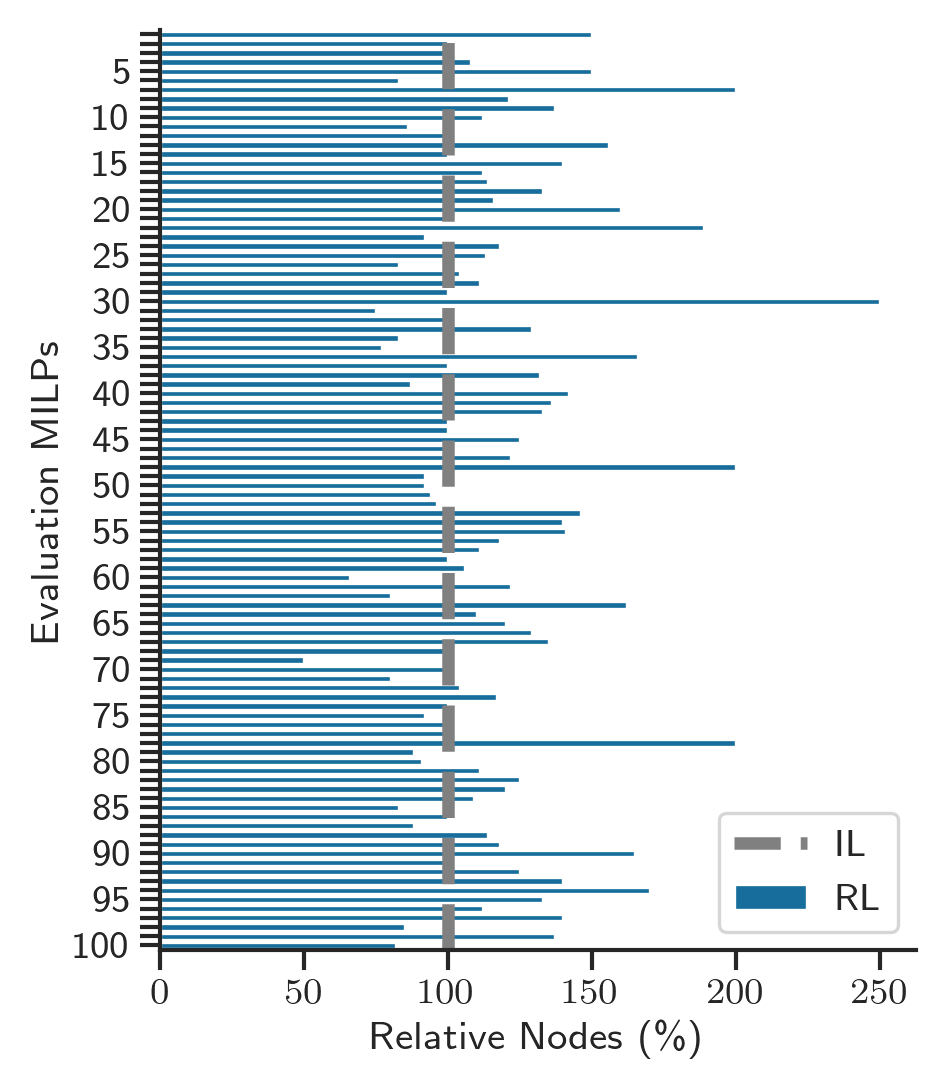

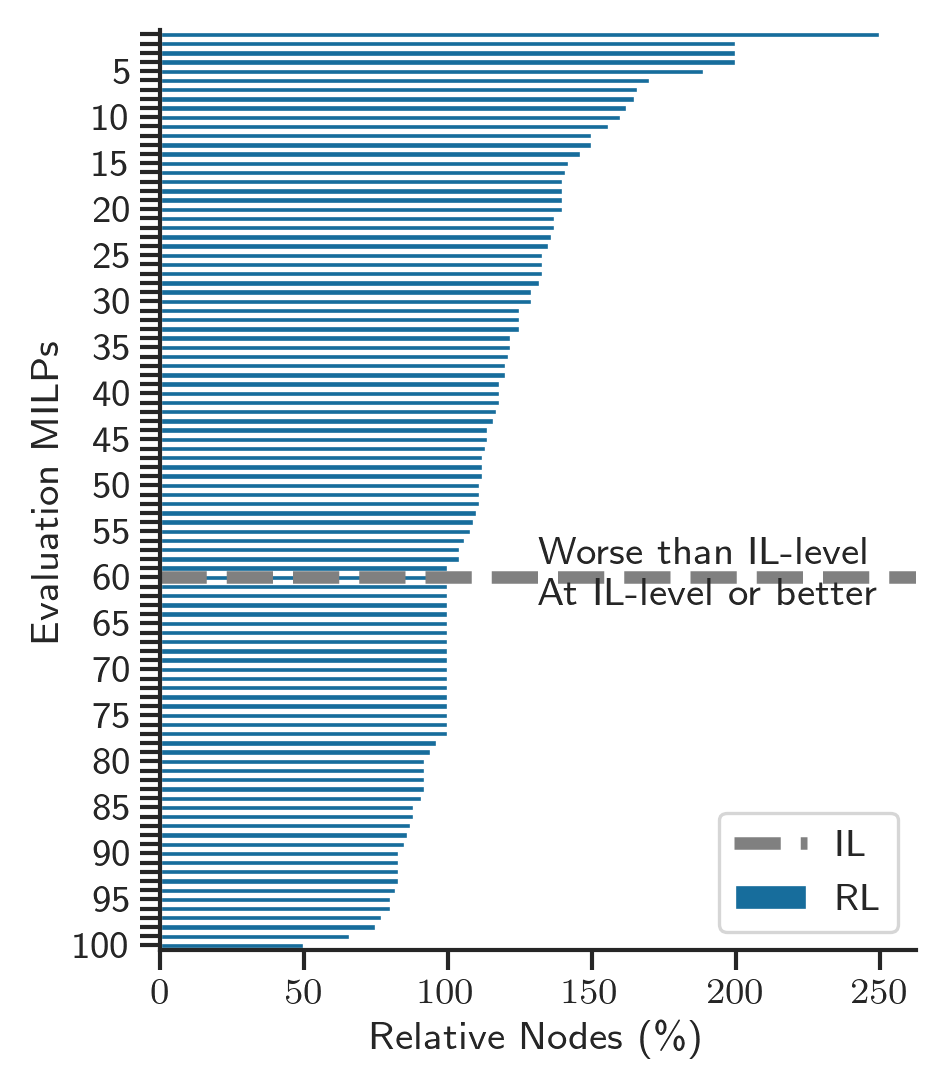

In [164]:
%autoreload

# sns.set_theme(font_scale=font_scale,
#               context=context,
#               style=style,
#               palette=palette)

if baseline_metric == 'calibrated_solve_time':
    xlabel = 'Relative Calibrated Solve Time'
elif baseline_metric == 'num_nodes':
    xlabel = 'Relative Nodes'
elif baseline_metric == 'lp_iterations':
    xlabel = 'Relative LP Iterations'
else:
    raise Exception(f'Unrecognised baseline_metric {baseline_metric}, implement xlabel for this.')
    
if use_percentages:
    xlabel += ' (\%)'
    axvline_x = 100
else:
    axvline_x = 1

f, ax = plt.subplots(figsize=aesthetics.get_winner_bar_fig_size())
g = sns.barplot(data=filter_rows_by_values(df, 'Agent', [competitor_agent]), 
                x=f'normalised_{baseline_metric}', 
                y='Instance', 
                hue='Agent', 
                orient='h')
g.set_xlabel(xlabel)
g.set_ylabel('Evaluation MILPs')
plt.axvline(x=axvline_x, linestyle='--', label=baseline_agent, alpha=1, color=axvline_color, linewidth=axvline_linewidth)
for label in ax.yaxis.get_ticklabels():
    if label.get_text() in ylabels:
        label.set_visible(True)
    else:
        label.set_visible(False) 
ax.legend(ncol=1, frameon=True, loc='lower right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
plt.gcf().patch.set_alpha(0.0)
plt.show()




f, ax = plt.subplots(figsize=aesthetics.get_winner_bar_fig_size())
g = sns.barplot(data=sorted_agent_normalised_df, 
                x=f'normalised_{baseline_metric}',
                y='Instance', 
                hue='Agent', 
                orient='h')
g.set_xlabel(xlabel)
g.set_ylabel('Evaluation MILPs')
prev_instance = None
for idx, instance in enumerate(sorted_agent_normalised_df['Instance']):
    if sorted_agent_normalised_df[f'normalised_{baseline_metric}'][idx] <= axvline_x:
        # all values below this y-axis value better than or equal to baseline
        if prev_instance is not None:
            instance = prev_instance
        break
    prev_instance = instance
instance += 1
plt.axhline(y=instance, linestyle='--', label=baseline_agent, alpha=1, color=axvline_color, linewidth=axvline_linewidth)
ax.text(0.5, instance+3, f'At {baseline_agent}-level or better', transform=ax.get_yaxis_transform())
ax.text(0.5, instance-1.5, f'Worse than {baseline_agent}-level', transform=ax.get_yaxis_transform())
for label in ax.yaxis.get_ticklabels():
    if label.get_text() in ylabels:
        label.set_visible(True)
    else:
        label.set_visible(False)
        
ax.legend(ncol=1, frameon=True, loc='lower right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
plt.gcf().patch.set_alpha(0.0)
plt.show()

/scratch/zciccwf/py36/envs/rlgnn/lib/python3.7/site-packages/ipykernel_launcher.py:74: UserWarning: FixedFormatter should only be used together with FixedLocator


57.9


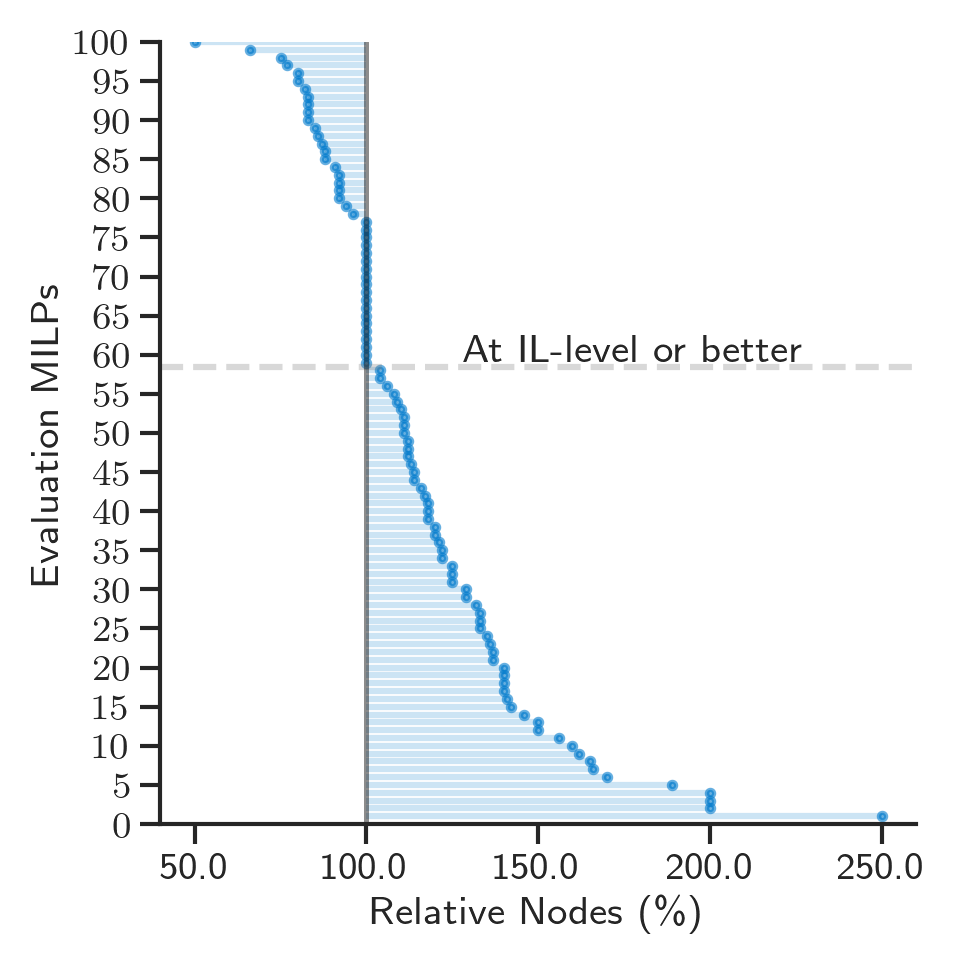

In [165]:
%autoreload

shift_axis = True
barwidth = 6 * 0.25
baralpha = 0.2
markersize = 7 * 0.25
markeralpha = 0.6

# shift x-axis values
new_sorted_agent_normalised_df = copy.deepcopy(sorted_agent_normalised_df)
new_sorted_agent_normalised_df[f'normalised_{baseline_metric}'] = new_sorted_agent_normalised_df[f'normalised_{baseline_metric}'][::-1]
if shift_axis:
    new_sorted_agent_normalised_df[f'normalised_{baseline_metric}'] = new_sorted_agent_normalised_df[f'normalised_{baseline_metric}'] - 100

# init plot
figsize = aesthetics.get_winner_bar_fig_size()
figsize = list(figsize)
figsize[-1] *= height_scaling_factor
figsize = tuple(figsize)
f, ax = plt.subplots(figsize=figsize)

# init placeholders for y-axis
my_range = list(range(1,len(new_sorted_agent_normalised_df.index)+1))

# draw horizontal bars for each data point
plt.hlines(y=my_range, 
           xmin=0, 
           xmax=new_sorted_agent_normalised_df[f'normalised_{baseline_metric}'], 
           color='#007acc', 
           alpha=baralpha, 
           linewidth=barwidth)
plt.plot(new_sorted_agent_normalised_df[f'normalised_{baseline_metric}'], my_range, "o", markersize=markersize, color='#007acc', alpha=markeralpha)
# ax.set_xlabel(xlabel, fontsize=15, fontweight='black', color = '#333F4B')
ax.set_xlabel(xlabel)
ax.set_ylabel('Evaluation MILPs')

# draw horizontal line indicating baseline level
prev_instance = None
for idx, instance in enumerate(sorted_agent_normalised_df['Instance']):
    if sorted_agent_normalised_df[f'normalised_{baseline_metric}'][idx] <= axvline_x:
        # all values below this y-axis value better than or equal to baseline
        if prev_instance is not None:
            instance = prev_instance
        break
    prev_instance = instance
instance -= 0.1
plt.axhline(y=instance+0.5, linestyle='--', label=baseline_agent, alpha=0.3, color=axvline_color, linewidth=barwidth)
# ax.text(0.015, instance+1.25, f'At {baseline_agent}-level\n or better', transform=ax.get_yaxis_transform())
# ax.text(0.5, instance+1.25, f'At {baseline_agent}-level\n or better', transform=ax.get_yaxis_transform())
ax.text(0.4, instance+1.25, f'At {baseline_agent}-level or better', transform=ax.get_yaxis_transform())
# ax.text(0.375, instance+1.25, f'At {baseline_agent}-level or better', transform=ax.get_yaxis_transform())
# ax.text(0.015, instance-1.25, f'Worse than {baseline_agent}-level', transform=ax.get_yaxis_transform())

# draw vertical line marking starting point
plt.axvline(x=0, alpha=0.5, color='k')

# init yticks
plt.yticks(np.arange(0, num_instances+1, ytick_separation))

if shift_axis:
    # explicitly draw fig to force setting of xticks so can overwrite
    f.canvas.draw()
    # get axis labels
    labels = [label.get_text() for label in ax.xaxis.get_ticklabels()]
    # remove any bad minus characters
    for idx, label in enumerate(labels):
        for i in range(len(label)):
            if label[i] == '−':
                labels[idx] = '{-' + label[i+1:]
    # overwrite axis labels
#     new_labels = [str(int(label)+100) for label in labels]
    new_labels = [str(float(label[label.index('{')+1:label.index('}')])+100) for label in labels]
    
    ax.xaxis.set_ticklabels(new_labels)

# # overwrite yticks
# for label in ax.yaxis.get_ticklabels():
#     if label.get_text() in ylabels:
#         label.set_visible(True)
#     else:
#         label.set_visible(False)
        
# format axes
ax.spines['bottom'].set_position(('data', 0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', pad=2)
ax.xaxis.labelpad = 2
ax.yaxis.labelpad = 2
plt.ylim(bottom=0, top=100)

print(instance)

plt.gcf().patch.set_alpha(0.0)
plt.show()